# Set up environment

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow.keras.utils as utils

import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import requests

## Declare parameters

In [3]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

IMAGE_SIZE = 299

API_KEY = "4INghUtThsIBWPTIcvfKyf0kNS6MtSXcC4R6mpNB"
BASE_URL = "https://api.nal.usda.gov/fdc/v1/"

## Enable GPU

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

## Declare model architecture

Currently supports:
    - inception_v3
    - mobilenet_v2
    - wide_resnet_101

In [5]:
MODEL_NAME = "wide_resnet_101"

## Fetch model architecture

In [6]:
print("Fetching model... ", end="")

# fetch feature extractor
if MODEL_NAME == "inception_v3":
    model = torchvision.models.inception_v3(pretrained=False)
elif MODEL_NAME == "mobilenet_v2":
    model = torchvision.models.mobilenet_v2(pretrained=False)
elif MODEL_NAME == "wide_resnet_101":
    model = torchvision.models.wide_resnet101_2(pretrained=False)

# replace classification head
if MODEL_NAME == "inception_v3":
    # handle auxilary net
    num_features = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

    # handle primary net
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "mobilenet_v2":
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "wide_resnet_101":
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)

model = model.to(device)
print("done")

Fetching model... done


## Load model weights

In [7]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", MODEL_NAME, "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Input class names

In [8]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TEST_DIR = os.path.join(FOOD101_DIR, "test")

test_raw = torchvision.datasets.ImageFolder(TEST_DIR)

class_names = test_raw.classes

# Predict on image

## Load image from url

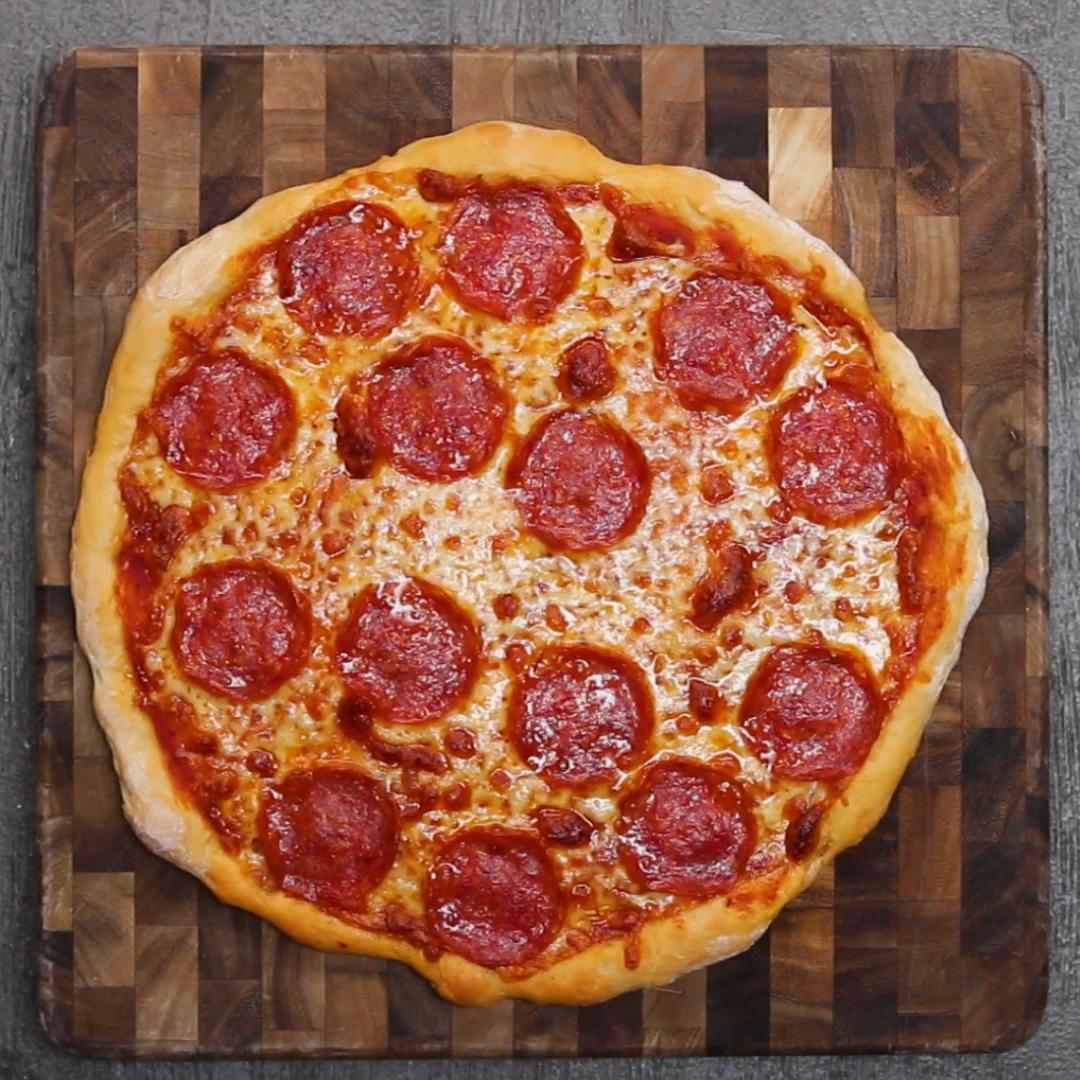

In [69]:
url = "https://img.buzzfeed.com/thumbnailer-prod-us-east-1/dc23cd051d2249a5903d25faf8eeee4c/BFV36537_CC2017_2IngredintDough4Ways-FB.jpg"

def loadImage(url):
    filename = url.split('/')[-1]
    img = utils.get_file(filename, url)
    img = Image.open(img)
    return img

img = loadImage(url)
img

## Format image for model input

In [70]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

x = transform(img)
x = x.unsqueeze(0)

## Run inference on image

In [71]:
x = x.to(device)
model.eval()
    
with torch.no_grad():
    outputs = model(x)
    _, predictions = torch.max(outputs, 1)
    
img_class = class_names[predictions[0]].replace('_', ' ')

img_class

'pizza'

# Weight estimation

The next step is to estimate the weight of the food present for more accurate nutritional information.

## Calculate surface area

The first stage to estimating the portion size is to calculate the surface area of food visible. In order to do so we assume a standard plate diameter of 25cm and assume that the plate spans accross the whole image. Since we don't have a database of food shapes we will also assume the captured food posses an eliptical shape.

In [72]:
PLATE_DIAMETER = 30 # cm
MARGIN = 2 # cms of food from plate edge

# estimate cms per pixel using standard plate diameter
cm_per_pixel = PLATE_DIAMETER / min(img.size)

# estimate food dimensions taking into consideration margin from plate
width, height = img.size
width = width * cm_per_pixel - 2 * MARGIN
height = height * cm_per_pixel - 2 * MARGIN

# estimate surface area using an oval shape (Pi * height/2 * width/2)
surface_area = np.pi * height/2 * width/2

print("Surface Area: {0} cm^2".format(surface_area))

Surface Area: 530.929158456675 cm^2


## Show overlay of calculated surface area with actual food image

Surface area is taken to be area within blue circle.

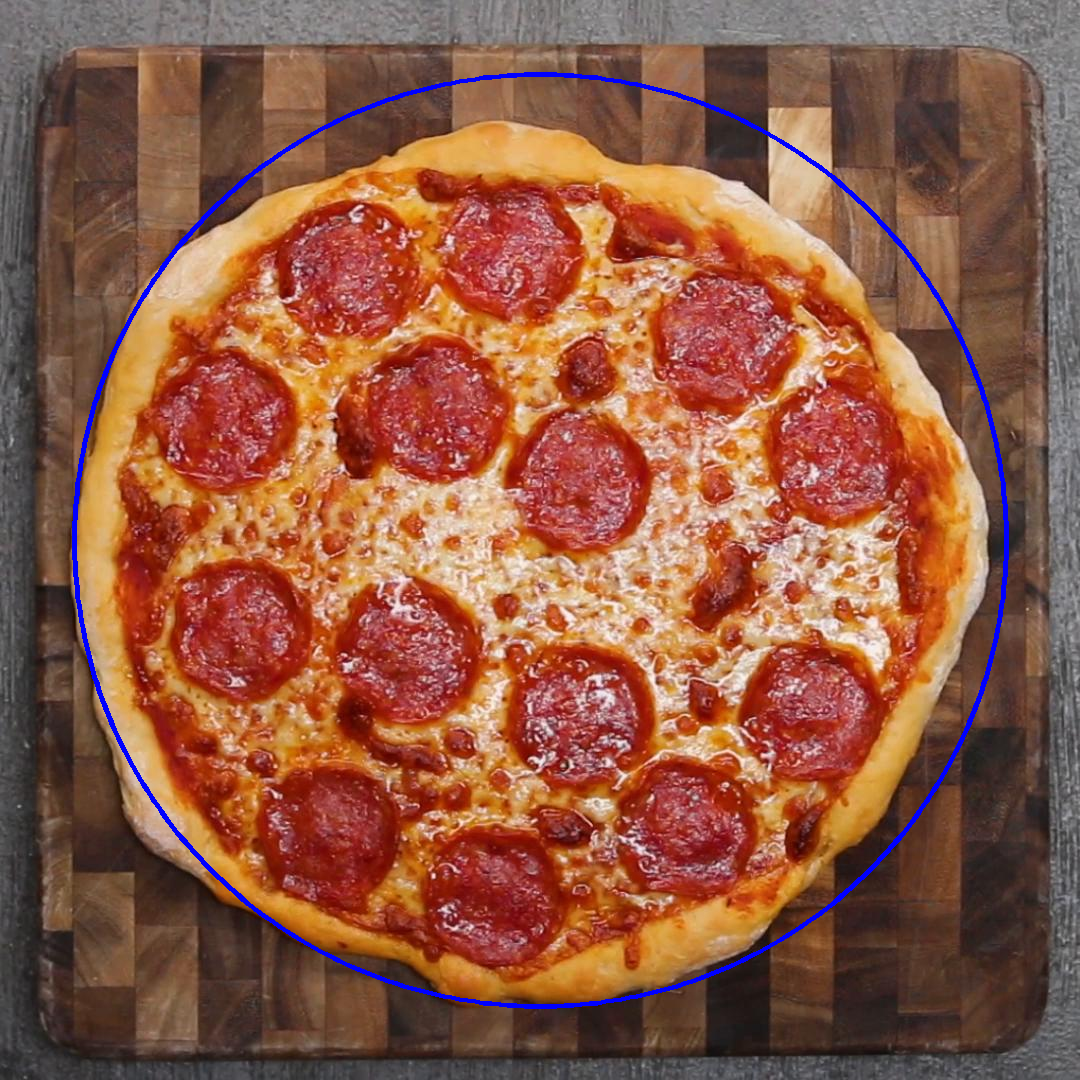

In [73]:
# calculate number of pixels in margin
margin_pixels = MARGIN / cm_per_pixel

draw = ImageDraw.Draw(img)
draw.ellipse((margin_pixels, margin_pixels, img.size[0] - margin_pixels, img.size[1] - margin_pixels), outline ='blue', width=5)

img

## Estimate volume

The next step is to estimate the volume of the food by using its given depth. In practice, this depth could be infered from a depth map.

In [74]:
FOOD_DEPTH = 1 # cm

volume = surface_area * FOOD_DEPTH

print("Volume: {0} cm^3".format(volume))

Volume: 530.929158456675 cm^3


## Estimate weight

The final stage is to infer the portion weight using a standard food density. We can use http://foodinfo.us/Densities to lookup density values.

In [75]:
DENSITY = 0.57 # g per cm^3

weight = volume * DENSITY

print("Weight: {0} g".format(weight))

Weight: 302.62962032030475 g


# Nutritional lookup

## Perform lookup of food item

Using the FoodData Central API we perform a lookup for the food item using the class as the search query

In [77]:
# seach FoodData Central with class name as search term
url = BASE_URL+"search"
params = {
    'api_key': API_KEY,
    'generalSearchInput': img_class
}
data = requests.get(url=url, params=params).json()

# take foodId from first result
if len(data['foods']) > 0:
    food_id = data['foods'][0]['fdcId']
else:
    print("Unable to find food with class {0}".format(img_class))

## Retrieve food information

We then request its nutritional contents and typical ingredients using the foodId retrieved.

In [78]:
# query FoodDataCentral for report
url = BASE_URL+str(food_id)
params = {
    'api_key': API_KEY
}
data = requests.get(url=url, params=params).json()
data

{'foodClass': 'Branded',
 'description': 'PIZZA',
 'foodNutrients': [{'type': 'FoodNutrient',
   'id': 2946532,
   'nutrient': {'id': 1087,
    'number': '301',
    'name': 'Calcium, Ca',
    'rank': 5300,
    'unitName': 'mg'},
   'foodNutrientDerivation': {'id': 75,
    'code': 'LCCD',
    'description': 'Calculated from a daily value percentage per serving size measure',
    'foodNutrientSource': {'id': 9,
     'code': '12',
     'description': "Manufacturer's analytical; partial documentation"}},
   'amount': 133.0},
  {'type': 'FoodNutrient',
   'id': 2946533,
   'nutrient': {'id': 1089,
    'number': '303',
    'name': 'Iron, Fe',
    'rank': 5400,
    'unitName': 'mg'},
   'foodNutrientDerivation': {'id': 75,
    'code': 'LCCD',
    'description': 'Calculated from a daily value percentage per serving size measure',
    'foodNutrientSource': {'id': 9,
     'code': '12',
     'description': "Manufacturer's analytical; partial documentation"}},
   'amount': 2.39},
  {'type': 'FoodN

## Extract ingredients and compare with given allergies

In [86]:
ALLERGIES = ["cheese", "milk", "peanut"]

for allergy in ALLERGIES:
    if allergy.lower() in data["ingredients"].lower():
        print("May contain {0}".format(allergy))

May contain cheese
May contain milk


## Extract nutritional contents

In [98]:
for nutrient in data["foodNutrients"]:
    print("{0}: {1:.2f} {2}".format(nutrient["nutrient"]["name"], nutrient["amount"] * weight / 100, nutrient["nutrient"]["unitName"]))

Calcium, Ca: 402.50 mg
Iron, Fe: 7.23 mg
Vitamin A, IU: 402.50 IU
Vitamin C, total ascorbic acid: 8.17 mg
Protein: 30.81 g
Total lipid (fat): 34.80 g
Carbohydrate, by difference: 92.39 g
Energy: 801.97 kcal
Sugars, total including NLEA: 16.07 g
Fiber, total dietary: 5.45 g
Sodium, Na: 1258.94 mg
Cholesterol: 54.47 mg
Fatty acids, total trans: 0.00 g
Fatty acids, total saturated: 18.73 g
